<a href="https://colab.research.google.com/github/saba-ramezani/Medical_Symptom_to_Disease_Prediction_NLP/blob/main/Medical_Symptom_to_Disease_Prediction_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Symptom to Disease Prediction NLP

## 1. Install dependencies

In [14]:
# !pip install scikit-learn pandas numpy seaborn matplotlib shap umap-learn transformers torch --quiet
# !pip install transformers datasets evaluate --quiet
# !pip install spacy --quiet
# !python -m spacy download en_core_web_sm --quiet


## 2. Load Symptoms2Disease kaggle dataset

In [15]:
import pandas as pd

# Load the dataset
url = "/content/drive/MyDrive/MedicalProjects/NLP/Disease_Prediction/Dataset/Symptom2Disease.csv"
df = pd.read_csv(url)

# Inspect the dataset
df = df[['label', 'text']]
df.head()

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."


In [16]:
df.shape

(1200, 2)

## 3. Data analysis & visualization

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipython-input-500971096.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.index, y=disease_counts.values, palette="viridis")


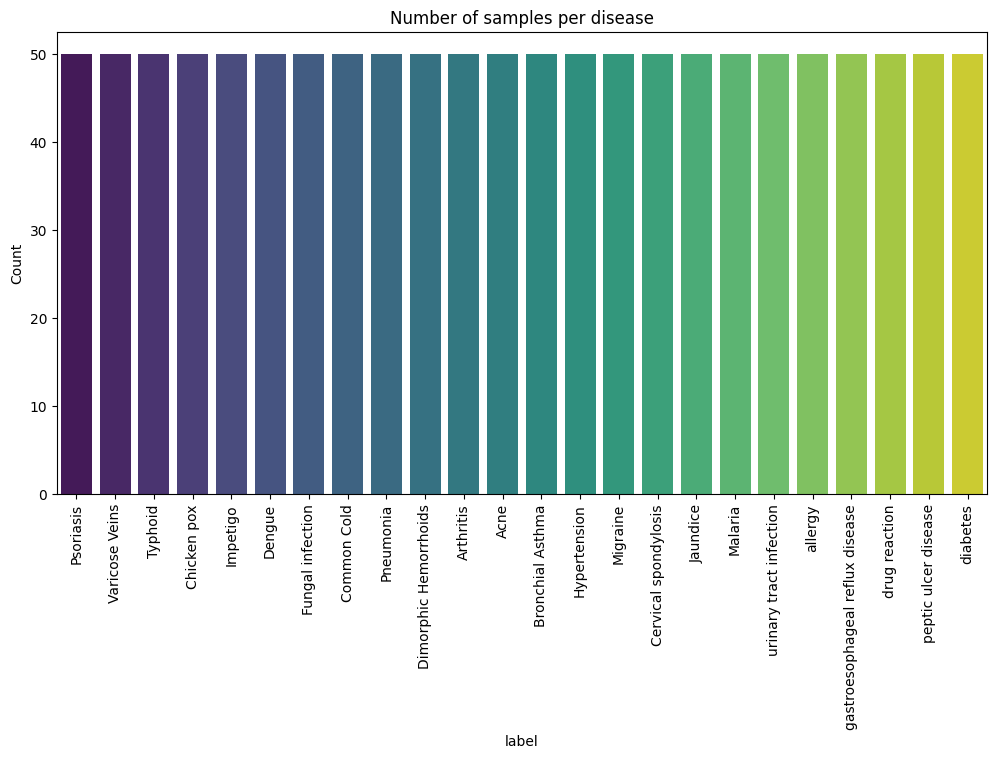

24

In [18]:
# Number of diseases
disease_counts = df['label'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Number of samples per disease")
plt.ylabel("Count")
plt.show()

len(disease_counts)

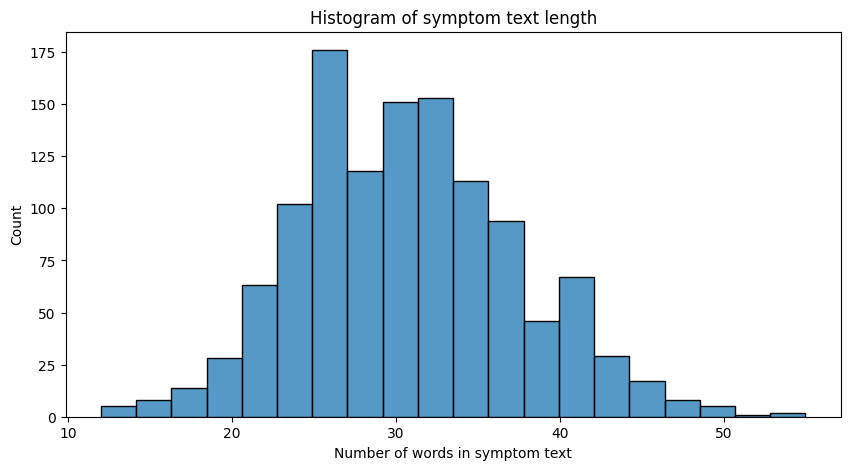

In [19]:
# Text length analysis
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,5))
sns.histplot(df['text_len'], bins=20)
plt.title("Histogram of symptom text length")
plt.xlabel("Number of words in symptom text")
plt.show()

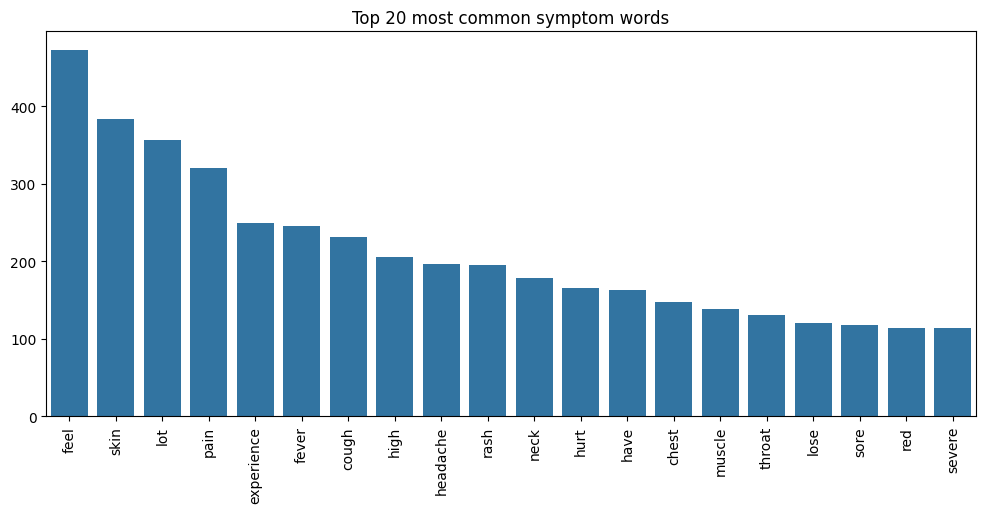

In [27]:
# Example: most common words
from collections import Counter
import spacy
nlp = spacy.load("en_core_web_sm")

all_tokens = [token.lemma_.lower() for doc in nlp.pipe(df['text'], batch_size=50) for token in doc if token.is_alpha and not token.is_stop]
counter = Counter(all_tokens)
most_common_words = counter.most_common(20)
plt.figure(figsize=(12,5))
sns.barplot(x=[w[0] for w in most_common_words], y=[w[1] for w in most_common_words])
plt.title("Top 20 most common symptom words")
plt.xticks(rotation=90)
plt.show()


## 4. Preprocess data using Spacy

In [28]:
def preprocess(text):
    doc = nlp(str(text).lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess)


In [29]:
df.head()

,label,text,text_len,clean_text
0,Psoriasis,I have been experiencing a skin rash on my arm...,28,experience skin rash arm leg torso past week r...
1,Psoriasis,"My skin has been peeling, especially on my kne...",23,skin peel especially knee elbow scalp peeling ...
2,Psoriasis,I have been experiencing joint pain in my fing...,28,experience joint pain finger wrist knee pain a...
3,Psoriasis,"There is a silver like dusting on my skin, esp...",32,silver like dust skin especially low scalp dus...
4,Psoriasis,"My nails have small dents or pits in them, and...",27,nail small dent pit feel inflammatory tender t...


## 5. Label Encoding & Train/Test Split

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label_encoded'], test_size=0.2, random_state=42, stratify=df['label_encoded']
)


In [32]:
df

,label,text,text_len,clean_text,label_encoded
0,Psoriasis,I have been experiencing a skin rash on my arm...,28,experience skin rash arm leg torso past week r...,15
1,Psoriasis,"My skin has been peeling, especially on my kne...",23,skin peel especially knee elbow scalp peeling ...,15
2,Psoriasis,I have been experiencing joint pain in my fing...,28,experience joint pain finger wrist knee pain a...,15
3,Psoriasis,"There is a silver like dusting on my skin, esp...",32,silver like dust skin especially low scalp dus...,15
4,Psoriasis,"My nails have small dents or pits in them, and...",27,nail small dent pit feel inflammatory tender t...,15
...,...,...,...,...,...
1195,diabetes,I'm shaking and trembling all over. I've lost ...,25,shake tremble lose sense taste smell exhausted...,19
1196,diabetes,"Particularly in the crevices of my skin, I hav...",25,particularly crevice skin skin rash irritation...,19
1197,diabetes,I regularly experience these intense urges and...,23,regularly experience intense urge want urinate...,19
1198,diabetes,"I have trouble breathing, especially outside. ...",24,trouble breathing especially outside start fee...,19


In [33]:
X_train.shape, X_test.shape

((960,), (240,))

## 6. Train & Test Baseline Models (TF-IDF + LogisticRegression, SVM, NaiveBayes)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB()
}

results_baseline = {}
for name, model in baseline_models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    results_baseline[name] = (acc, f1)
    print(f"\n{name} Classification Report")
    print(classification_report(y_test, preds, target_names=le.classes_))



Logistic Regression Classification Report
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       1.00      1.00      1.00        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       0.83      1.00      0.91        10
                    Common Cold       1.00      1.00      1.00        10
                         Dengue       1.00      0.80      0.89        10
          Dimorphic Hemorrhoids       1.00      1.00      1.00        10
               Fungal infection       0.91      1.00      0.95        10
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       1.00      1.00      1.00        10
                       Jaundice       1.00      1.00      1.00        10
       

## 7. Embedding Models (SBERT, MiniLM, BioBERT)

In [36]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

embedding_models = {
    "SBERT-all-MiniLM": 'all-MiniLM-L6-v2',
    "Bio_ClinicalBERT": 'emilyalsentzer/Bio_ClinicalBERT',
}

embedding_results = {}

for emb_name, emb_model_name in embedding_models.items():
    print(f"Encoding with {emb_name} ...")
    sbert_model = SentenceTransformer(emb_model_name)
    train_emb = sbert_model.encode(X_train.tolist(), convert_to_tensor=True)
    test_emb = sbert_model.encode(X_test.tolist(), convert_to_tensor=True)

    # Predict top-1
    preds = []
    for q_emb in test_emb:
        cos_scores = util.cos_sim(q_emb, train_emb)[0]
        top_idx = np.argmax(cos_scores.cpu().numpy())
        preds.append(y_train.iloc[top_idx])
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    embedding_results[emb_name] = (acc, f1)
    print(f"{emb_name}: Accuracy={acc:.4f}, Macro-F1={f1:.4f}")


Encoding with SBERT-all-MiniLM ...


SBERT-all-MiniLM: Accuracy=0.9625, Macro-F1=0.9610
Encoding with Bio_ClinicalBERT ...


vocab.txt: 0.00B [00:00, ?B/s]

Bio_ClinicalBERT: Accuracy=0.9167, Macro-F1=0.9133


## 8. Fine-tune Transformers (DistilBERT, BioBERT, ClinicalBERT)

In [40]:
# !pip install transformers datasets evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [41]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [43]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

hf_df = df[['clean_text','label_encoded']].rename(columns={'clean_text':'text','label_encoded':'label'})
dataset = Dataset.from_pandas(hf_df)

train_testvalid = dataset.train_test_split(test_size=0.2, seed=42)
train_valid = train_testvalid['train'].train_test_split(test_size=0.1, seed=42)
train_dataset = train_valid['train']
val_dataset = train_valid['test']
test_dataset = train_testvalid['test']

transformers_to_finetune = [
    'distilbert-base-uncased',
    'emilyalsentzer/Bio_ClinicalBERT'
]

ft_results = {}

for model_name in transformers_to_finetune:
    print(f"\nFine-tuning {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_fn(batch):
        return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

    train_dataset_tok = train_dataset.map(tokenize_fn, batched=True)
    val_dataset_tok = val_dataset.map(tokenize_fn, batched=True)
    test_dataset_tok = test_dataset.map(tokenize_fn, batched=True)

    train_dataset_tok.set_format(type='torch', columns=['input_ids','attention_mask','label'])
    val_dataset_tok.set_format(type='torch', columns=['input_ids','attention_mask','label'])
    test_dataset_tok.set_format(type='torch', columns=['input_ids','attention_mask','label'])

    num_labels = len(df['label_encoded'].unique())
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)
        return {
            "accuracy": accuracy.compute(predictions=preds, references=labels)['accuracy'],
            "f1_macro": f1.compute(predictions=preds, references=labels, average='macro')['f1']
        }

    training_args = TrainingArguments(
        output_dir=f"./results_{model_name.replace('/','_')}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01,
        logging_dir=f"./logs_{model_name.replace('/','_')}",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        report_to="none"

    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_tok,
        eval_dataset=val_dataset_tok,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    metrics = trainer.evaluate(test_dataset_tok)
    ft_results[model_name] = (metrics['eval_accuracy'], metrics['eval_f1_macro'])
    print(f"{model_name}: Accuracy={metrics['eval_accuracy']:.4f}, Macro-F1={metrics['eval_f1_macro']:.4f}")



Fine-tuning distilbert-base-uncased


Map:   0%|          | 0/864 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-669176700.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,2.853638,0.562500,0.429258
2,No log,2.230485,0.770833,0.755788
3,No log,1.721754,0.812500,0.770063
4,No log,1.348143,0.875000,0.859810
5,No log,1.081393,0.906250,0.880420
6,No log,0.887962,0.916667,0.909411
7,No log,0.751258,0.916667,0.923019
8,No log,0.665486,0.927083,0.934199
9,No log,0.611721,0.937500,0.941031
10,1.474700,0.594152,0.937500,0.941031


distilbert-base-uncased: Accuracy=0.9458, Macro-F1=0.9393

Fine-tuning emilyalsentzer/Bio_ClinicalBERT


Map:   0%|          | 0/864 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-669176700.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,2.894616,0.218750,0.152742
2,No log,2.220567,0.614583,0.596177
3,No log,1.686472,0.760417,0.730540
4,No log,1.310947,0.802083,0.769475
5,No log,1.046354,0.864583,0.842387
6,No log,0.847215,0.895833,0.880622
7,No log,0.731999,0.916667,0.917907
8,No log,0.654659,0.895833,0.881657
9,No log,0.604698,0.906250,0.891821
10,1.392000,0.584738,0.906250,0.891821


emilyalsentzer/Bio_ClinicalBERT: Accuracy=0.8958, Macro-F1=0.8818


## 9. Compare & Plot Results

                             Model  Accuracy  Macro F1
1                              SVM  0.962500  0.961413
3                 SBERT-all-MiniLM  0.962500  0.961020
0              Logistic Regression  0.950000  0.949631
5          distilbert-base-uncased  0.945833  0.939275
2                      Naive Bayes  0.929167  0.926674
4                 Bio_ClinicalBERT  0.916667  0.913298
6  emilyalsentzer/Bio_ClinicalBERT  0.895833  0.881780


/tmp/ipython-input-2833214811.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')


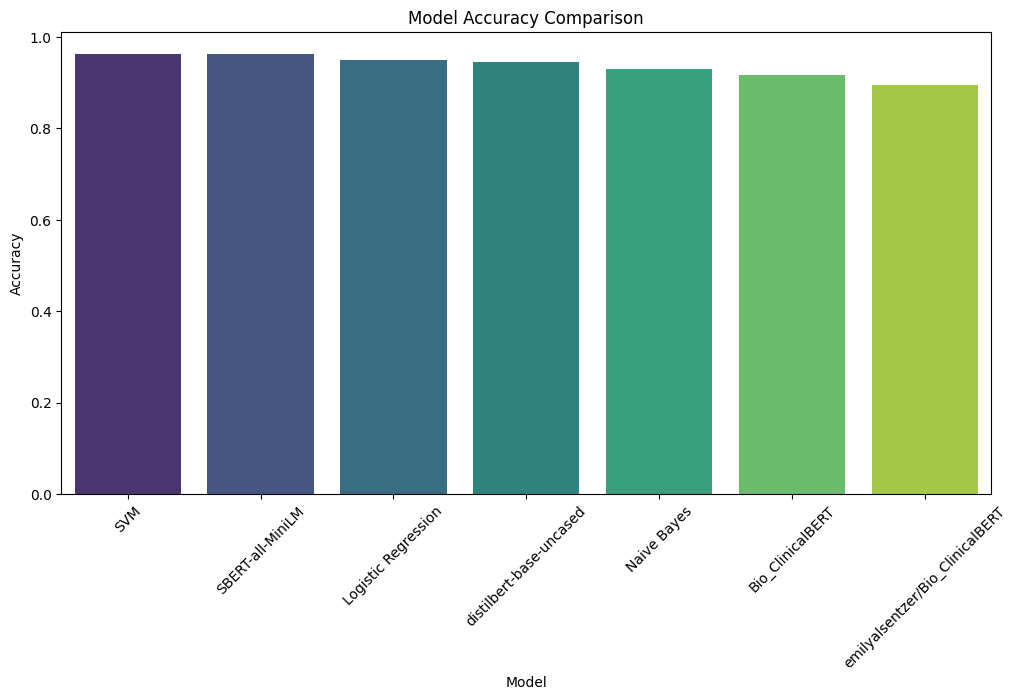

/tmp/ipython-input-2833214811.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Macro F1', palette='magma')


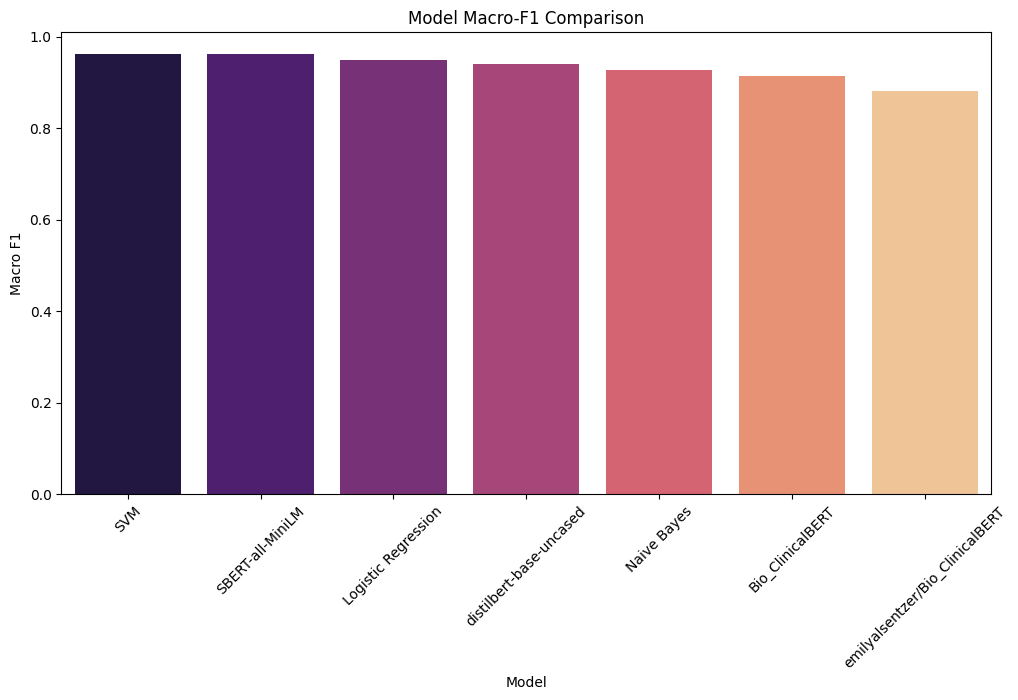

In [44]:
import matplotlib.pyplot as plt

# Combine all results
all_results = {}
all_results.update(results_baseline)
all_results.update(embedding_results)
all_results.update(ft_results)

results_df = pd.DataFrame([
    {'Model':k, 'Accuracy':v[0], 'Macro F1':v[1]} for k,v in all_results.items()
])
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x='Model', y='Macro F1', palette='magma')
plt.xticks(rotation=45)
plt.title("Model Macro-F1 Comparison")
plt.show()
